In [3]:
import torch
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt
import pickle

cr = 512
hori = 5
kmph = 120
H_test_stem = torch.load(f'F:\\CSIP\\{cr}_{kmph}\\H_test_{cr}_{kmph}_5_{hori}')
H_test_stem = H_test_stem[0:96,:,:]
H_test_tran = torch.load(f'F:\\CSIP\\{cr}_{kmph}\\H_test_{cr}_{kmph}_4_{hori}')
H_test_lstm = torch.load(f'F:\\CSIP\\{cr}_{kmph}\\H_test_{cr}_{kmph}_3_{hori}')
H_test_rnn = torch.load(f'F:\\CSIP\\{cr}_{kmph}\\H_test_{cr}_{kmph}_2_{hori}')

H_hat_stem = torch.load(f'F:\\CSIP\\{cr}_{kmph}\\H_hat_{cr}_{kmph}_5_{hori}')
H_hat_stem = H_hat_stem[0:96,:,:]
H_hat_tran = torch.load(f'F:\\CSIP\\{cr}_{kmph}\\H_hat_{cr}_{kmph}_4_{hori}')
H_hat_lstm = torch.load(f'F:\\CSIP\\{cr}_{kmph}\\H_hat_{cr}_{kmph}_3_{hori}')
H_hat_rnn = torch.load(f'F:\\CSIP\\{cr}_{kmph}\\H_hat_{cr}_{kmph}_2_{hori}')


# print(H_test_stem.size())
# print(H_test_lstm.size())
# print(H_hat_stem.size())
# print(H_hat_lstm.size())

def waterfilling(H,P):
    U, g, VT = svd(H)
#     print(np.shape(VT))
    alpha_low = 0 # Initial low
    alpha_high = (P + np.sum(1/g**2)) # Initial high

    stop_threshold = 1e-7 # Stop threshold

    # Iterate while low/high bounds are further than stop_threshold
    while(np.abs(alpha_low - alpha_high) > stop_threshold):
        alpha = (alpha_low + alpha_high) / 2 # Test value in the middle of low/high

        # Solve the power allocation
        p = 1/alpha - 1/g**2 
        p[p < 0] = 0 # Consider only positive power allocation

        # Test sum-power constraints
        if (np.sum(p) > P): # Exceeds power limit => lower the upper bound
            alpha_low = alpha
        else: # Less than power limit => increase the lower bound
            alpha_high = alpha
    return p

def sumrate(ebn,num, H_stem, Ht_stem, H_lstm, Ht_lstm, H_rnn, Ht_rnn, H_tran, Ht_tran):


    snr = 10**(ebn/10)
    sr = []
    sr_stem = []
    sr_lstm = []
    sr_rnn  = []
    sr_tran  = []
    
    power = np.zeros(32)
    p = 0
    capacity = 0
    
    power_stem = np.zeros(32)
    p_stem = 0
    capacity_stem = 0
    
    power_lstm = np.zeros(32)
    p_lstm = 0
    capacity_lstm = 0
    
    power_rnn = np.zeros(32)
    p_rnn = 0
    capacity_rnn = 0
    
    power_tran = np.zeros(32)
    p_tran = 0
    capacity_tran = 0
    
    H_stem = H_stem/np.linalg.norm(H_stem)
    Ht_stem = Ht_stem/np.linalg.norm(Ht_stem)
    
    H_lstm = H_lstm/np.linalg.norm(H_lstm)
    Ht_lstm = Ht_lstm/np.linalg.norm(Ht_lstm)
    
    H_rnn = H_rnn/np.linalg.norm(H_rnn)
    Ht_rnn = Ht_rnn/np.linalg.norm(Ht_rnn)
    
    H_tran = H_tran/np.linalg.norm(H_tran)
    Ht_tran = Ht_tran/np.linalg.norm(Ht_tran)
    
#     H = H_test_stem[num]/np.linalg.norm(H_test_stem[num])
#     Ht = H_hat_stem[num]/np.linalg.norm(H_hat_stem[num])
#     print(np.shape(H))
#     p_stem = 0
#     p_stem = waterfilling(H_hat_stem[num],snr)
#     print(p_stem)
    ##############################################################################
    for k in range(32):
        power[k] = np.abs(np.reshape(H_lstm[:,k],[1,32]) @ np.reshape(H_lstm[:,k].conj().T, [32,1]))**2 
        power[k] = power[k]/(np.abs(np.reshape(H_lstm[:,k],[1,32]) @ np.reshape(H_lstm[:,k].conj().T, [32,1]))**2)
#         power[k] = power[k]/(np.linalg.norm(np.reshape(H_lstm[:,k].conj().T, [32,1])/(np.abs(np.reshape(H_lstm[:,k],[1,32]) @ np.reshape(H_lstm[:,k].conj().T, [32,1]))**2)))
    
    p = np.abs(power)**2
    for i in range(32):
        capacity += np.log2(1 + p[k]*snr/32)/32;
    sr.append(capacity)
    ##############################################################################
    for k in range(32):
        power_stem[k] = np.abs(np.reshape(H_stem[:,k],[1,32]) @ np.reshape(Ht_stem[:,k].conj().T, [32,1]))**2 
        power_stem[k] = power_stem[k]/(np.abs(np.reshape(Ht_stem[:,k],[1,32]) @ np.reshape(Ht_stem[:,k].conj().T, [32,1]))**2)
#         power_stem[k] = power_stem[k]/(np.linalg.norm(np.reshape(Ht_stem[:,k].conj().T, [32,1])/(np.abs(np.reshape(Ht_stem[:,k],[1,32]) @ np.reshape(Ht_stem[:,k].conj().T, [32,1]))**2)))
    
    p_stem = np.abs(power_stem)**2
    for i in range(32):
        capacity_stem += np.log2(1 + p_stem[k]*snr/32)/32;
    sr_stem.append(capacity_stem)
    ###############################################################################
    for k in range(32):
        power_tran[k] = np.abs(np.reshape(H_tran[:,k],[1,32]) @ np.reshape(Ht_tran[:,k].conj().T, [32,1]))**2 
        power_tran[k] = power_tran[k]/(np.abs(np.reshape(Ht_tran[:,k],[1,32]) @ np.reshape(Ht_tran[:,k].conj().T, [32,1]))**2)
#         power_tran[k] = power_tran[k]/(np.linalg.norm(np.reshape(Ht_tran[:,k].conj().T, [32,1])/(np.abs(np.reshape(Ht_tran[:,k],[1,32]) @ np.reshape(Ht_tran[:,k].conj().T, [32,1]))**2)))
    
    p_tran = np.abs(power_tran)**2
    for i in range(32):
        capacity_tran += np.log2(1 + p_tran[k]*snr/32)/32;
    sr_tran.append(capacity_tran)
    ###############################################################################
    for k in range(32):
        power_lstm[k] = np.abs(np.reshape(H_lstm[:,k],[1,32]) @ np.reshape(Ht_lstm[:,k].conj().T, [32,1]))**2 
        power_lstm[k] = power_lstm[k]/(np.abs(np.reshape(Ht_lstm[:,k],[1,32]) @ np.reshape(Ht_lstm[:,k].conj().T, [32,1]))**2)
#         power_lstm[k] = power_lstm[k]/(np.linalg.norm(np.reshape(Ht_lstm[:,k].conj().T, [32,1])/(np.abs(np.reshape(Ht_lstm[:,k],[1,32]) @ np.reshape(Ht_lstm[:,k].conj().T, [32,1]))**2)))
    
    p_lstm = np.abs(power_lstm)**2
    for i in range(32):
        capacity_lstm += np.log2(1 + p_lstm[k]*snr/32)/32;
    sr_lstm.append(capacity_lstm)
    ###############################################################################
    for k in range(32):
        power_rnn[k] = np.abs(np.reshape(H_rnn[:,k],[1,32]) @ np.reshape(Ht_rnn[:,k].conj().T, [32,1]))**2 
        power_rnn[k] = power_rnn[k]/(np.abs(np.reshape(Ht_rnn[:,k],[1,32]) @ np.reshape(Ht_rnn[:,k].conj().T, [32,1]))**2)
#         power_rnn[k] = power_rnn[k]/(np.linalg.norm(np.reshape(Ht_rnn[:,k].conj().T, [32,1])/(np.abs(np.reshape(Ht_rnn[:,k],[1,32]) @ np.reshape(Ht_rnn[:,k].conj().T, [32,1]))**2)))
    
    p_rnn = np.abs(power_rnn)**2
    for i in range(32):
        capacity_rnn += np.log2(1 + p_rnn[k]*snr/32)/32;
    sr_rnn.append(capacity_rnn)
    
    
    
#     for k in range(32):
#         power_fnn[k] = np.abs(np.reshape(H_fnn[:,k],[1,32]) @ np.reshape(Ht_fnn[:,k].conj().T, [32,1]))**2 
#         power_fnn[k] = power_fnn[k]/(np.abs(np.reshape(Ht_fnn[:,k],[1,32]) @ np.reshape(Ht_fnn[:,k].conj().T, [32,1]))**2)
# #         power_fnn[k] = power_fnn[k]/(np.linalg.norm(np.reshape(Ht_fnn[:,k].conj().T, [32,1])/(np.abs(np.reshape(Ht_fnn[:,k],[1,32]) @ np.reshape(Ht_fnn[:,k].conj().T, [32,1]))**2)))
    
#     p_fnn = np.abs(power_fnn)**2
#     for i in range(32):
#         capacity_fnn += np.log2(1 + p_fnn[k]*snr/32)/32;
#     sr_fnn.append(capacity_fnn)
    
    
    return np.asarray(sr), np.asarray(sr_stem), np.asarray(sr_lstm), np.asarray(sr_rnn), np.asarray(sr_tran)

    
many = 96
ebn = list(range(0,31,5))
snr = [10**(x/10) for x in ebn]
sr = [[] for i in range(many)]
sr_stem = [[] for i in range(many)]
sr_lstm = [[] for i in range(many)]
sr_rnn = [[] for i in range(many)]
sr_tran = [[] for i in range(many)]

for i in ebn:
    print(i)
    for j in range(many):
#         print(j)
        sr0, sr1, sr2, sr3, sr4 = sumrate(i,j, H_test_stem[j], H_hat_stem[j], H_test_lstm[j], H_hat_lstm[j], H_test_rnn[j], H_hat_rnn[j], H_test_tran[j], H_hat_tran[j])  
        sr[j].append(sr0)
        sr_stem[j].append(sr1)
        sr_lstm[j].append(sr2)
        sr_rnn[j].append(sr3)
        sr_tran[j].append(sr4)

with open(f'sr_stem_{cr}_{kmph}', "wb") as fp:   #Pickling
    pickle.dump(sr_stem, fp)
with open(f'sr_tran_{cr}_{kmph}', "wb") as fp:   #Pickling
    pickle.dump(sr_tran, fp)
with open(f'sr_lstm_{cr}_{kmph}', "wb") as fp:   #Pickling
    pickle.dump(sr_lstm, fp)
with open(f'sr_rnn_{cr}_{kmph}', "wb") as fp:   #Pickling
    pickle.dump(sr_rnn, fp)


0
5
10
15
20
25
30


In [ ]:
%matplotlib qt 
import pickle

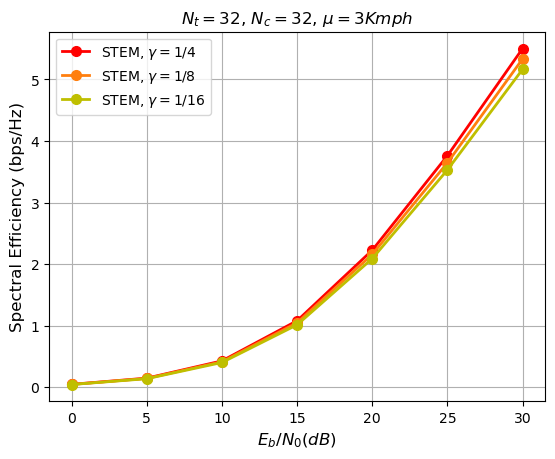

In [5]:
many = 96
with open("sr_stem_512_3", "rb") as fp:   # Unpickling
    sr_stem_512_3 = pickle.load(fp)


with open("sr_stem_256_3", "rb") as fp:   # Unpickling
    sr_stem_256_3 = pickle.load(fp)


with open("sr_stem_128_3", "rb") as fp:   # Unpickling
    sr_stem_128_3 = pickle.load(fp)


        
plt.plot(ebn,np.mean(sr_tran_256_3, axis=0), label=r'STEM, $\gamma = 1/4$', marker = 'o', ms = 7, c = 'r', linewidth=2)

plt.plot(ebn,np.mean(sr_tran_512_3, axis=0), label=r'STEM, $\gamma = 1/8$', marker = 'o', ms = 7, c = 'tab:orange', linewidth=2)

plt.plot(ebn,np.mean(sr_tran_128_3, axis=0), label=r'STEM, $\gamma = 1/16$', marker = 'o', ms = 7, c = 'y', linewidth=2)


plt.xlabel(r'$E_{b}/N_{0} (dB)$', fontsize = 12)
plt.ylabel("Spectral Efficiency (bps/Hz)", fontsize = 12)
plt.legend()
plt.title('$N_{t}=32$, $N_{c}=32$, $\mu = 3 Kmph$')
plt.grid(True)
plt.show()

In [30]:
print(np.mean(sr_stem_128_3, axis=0)[6])

[5.01305065]


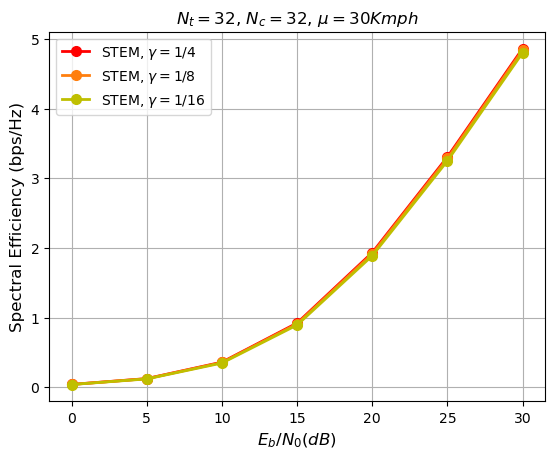

In [6]:
with open("sr_stem_512_30", "rb") as fp:   # Unpickling
    sr_stem_512_30 = pickle.load(fp)


with open("sr_stem_256_30", "rb") as fp:   # Unpickling
    sr_stem_256_30 = pickle.load(fp)


with open("sr_stem_128_30", "rb") as fp:   # Unpickling
    sr_stem_128_30 = pickle.load(fp)

        
plt.plot(ebn,np.mean(sr_stem_128_30, axis=0), label=r'STEM, $\gamma = 1/4$', marker = 'o', ms = 7, c = 'r', linewidth=2)

plt.plot(ebn,np.mean(sr_stem_512_30, axis=0), label=r'STEM, $\gamma = 1/8$', marker = 'o', ms = 7, c = 'tab:orange', linewidth=2)

plt.plot(ebn,np.mean(sr_stem_256_30, axis=0), label=r'STEM, $\gamma = 1/16$', marker = 'o', ms = 7, c = 'y', linewidth=2)

plt.xlabel(r'$E_{b}/N_{0} (dB)$', fontsize = 12)
plt.ylabel("Spectral Efficiency (bps/Hz)", fontsize = 12)
plt.legend()
plt.title('$N_{t}=32$, $N_{c}=32$, $\mu = 30 Kmph$')
plt.grid(True)
plt.show()